In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
data_path = 'data/'
# Load track data from csv file
track_data = pd.read_csv(os.path.join(data_path, 'Budapest-track.csv'))

racing_line_data = pd.read_csv(os.path.join(data_path, 'Budapest-raceline.csv'))

racing_line_data.shape

(864, 2)

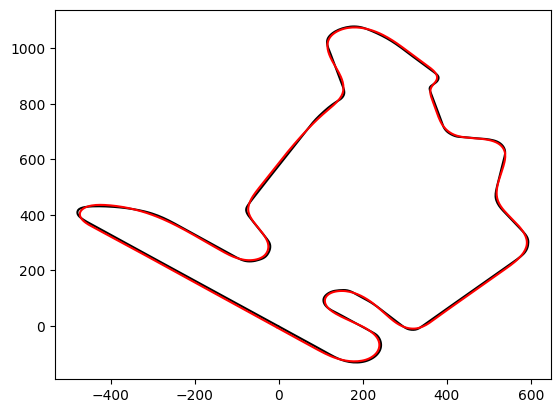

In [6]:
# Plot data points
fig, ax = plt.subplots()
ax.plot(track_data['x_m'], track_data['y_m'], 'k') # Track centerline
ax.plot(racing_line_data['x_m'], racing_line_data['y_m'], 'r') # Racing line

Pour dessiner les limites de la pistes on doit calculer les points appartenant à la ligne de limtie de gauche et de droite.
Pour se faire on a les distances à gauche à droite de la ligne du centre.

A partir d'un point de la ligne central on doit trouver les 2 points des limites correspondants. Pour définir la gauche et la droite on doit connaitre le direction du point.
La direction du point est définie par le vecteur $v_i$ formé par ce point $p_i$ et le point suivant $p_{i+1}$.

$$
    v_d = v_{i+1} - v_i
$$

In [7]:
def calculate_track_edge(data_point, next_data_point):
    v1 = data_point[['x_m', 'y_m']]
    v2 = next_data_point[['x_m', 'y_m']]
    d_left = data_point['w_tr_left_m']
    d_right = data_point['w_tr_right_m']

    v_direction = v2 - v1
    v_direction = v_direction / np.linalg.norm(v_direction) # normalize
    v_orthogonal = pd.Series(
        {
            'x_m': -v_direction['y_m'],
            'y_m': v_direction['x_m']
        }
    )

    left_edge = v1 + v_orthogonal * d_left
    right_edge = v1 - v_orthogonal * d_right

    return left_edge, right_edge

def apply_calculate_track_edge(data_point):
    next_data_point = pd.DataFrame(
        {
            'x_m': [data_point['next_x_m']],
            'y_m': [data_point['next_y_m']]
        }
    )
    left_edge, right_edge = calculate_track_edge(data_point, next_data_point.iloc[0])
    return left_edge[0], left_edge[1], right_edge[0], right_edge[1]

def calculate_track_edges(track_data):
    track_data = track_data.copy()
    track_data[['next_x_m', 'next_y_m']] = track_data[['x_m', 'y_m']].shift(-1).fillna(track_data[['x_m', 'y_m']].iloc[0])
    track_data[['left_edge_x_m', 'left_edge_y_m', 'right_edge_x_m', 'right_edge_y_m']] = track_data.apply(apply_calculate_track_edge, axis=1, result_type='expand')

    return track_data.drop(columns=['next_x_m', 'next_y_m', 'w_tr_left_m', 'w_tr_right_m'])

In [8]:
track_data = calculate_track_edges(track_data)

In [9]:
def draw_track(center_x=None, center_y=None, width=None, height=None):
    # Plot data points
    fig, ax = plt.subplots(figsize=(15, 15))
    if center_x is not None and center_y is not None and width is not None and height is not None:
        ax.set_xlim(center_x - width / 2, center_x + width / 2)
        ax.set_ylim(center_y - height / 2, center_y + height / 2)
    ax.plot(racing_line_data['x_m'], racing_line_data['y_m'], 'r') # Racing line
    ax.plot(track_data['left_edge_x_m'], track_data['left_edge_y_m'], 'k', linewidth=1) # Left edge
    ax.plot(track_data['right_edge_x_m'], track_data['right_edge_y_m'], 'k', linewidth=1) # Right edge
    return fig, ax

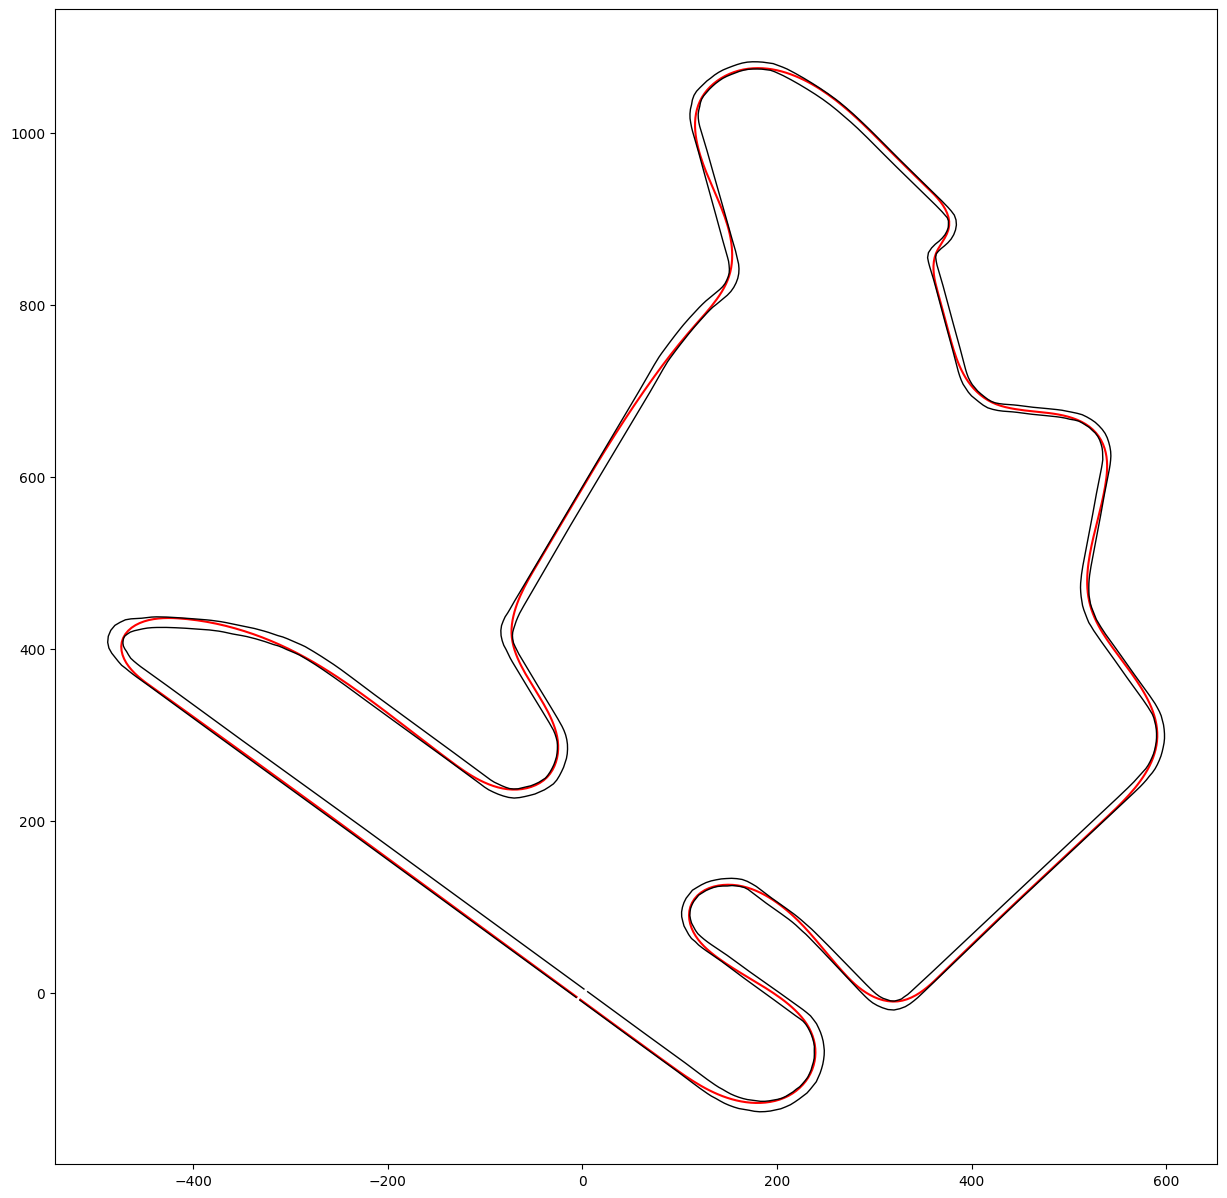

In [10]:
p1 = racing_line_data.iloc[0]
p2 = racing_line_data.iloc[1]

fig, ax = draw_track()
plt.savefig('fig/budapest.svg', format='svg')
#ax.scatter(p1['x_m'], p1['y_m'], 50, 'b')
#ax.scatter(p2['x_m'], p2['y_m'], 50, 'b')
#ax.grid()

On a une résolution de 864 points par tour pour Budapest. On peut essayer de calculer la distance en metres entre chaques points avec la distance euclidiène.

In [11]:
def circumcenter(A, B, C):
    """
    Compute the circumcenter of the triangle formed by points A, B, and C.
    """
    D = 2 * (A[0] * (B[1] - C[1]) + B[0] * (C[1] - A[1]) + C[0] * (A[1] - B[1]))
    
    # Check if the three points are collinear
    if D == 0:
        return None

    Ux = ((A[0] ** 2 + A[1] ** 2) * (B[1] - C[1]) + (B[0] ** 2 + B[1] ** 2) * (C[1] - A[1]) + (C[0] ** 2 + C[1] ** 2) * (A[1] - B[1])) / D
    Uy = ((A[0] ** 2 + A[1] ** 2) * (C[0] - B[0]) + (B[0] ** 2 + B[1] ** 2) * (A[0] - C[0]) + (C[0] ** 2 + C[1] ** 2) * (B[0] - A[0])) / D
    
    return (Ux, Uy)

def curvature(points):
    """
    Compute the curvature of a line defined by a set of points.
    """
    curvatures = []
    
    for i in range(1, len(points) - 1):
        A, B, C = points[i-1], points[i], points[i+1]
        
        center = circumcenter(A, B, C)
        
        if center is not None:
            r = np.linalg.norm(np.array(center) - np.array(A))
            curvatures.append(1/r)
        else:
            curvatures.append(0)  # curvature is 0 for collinear points
    
    # Padding the curvatures list to match the number of input points
    # First and last points will have curvature 0 as they don't have previous or next points
    return [0] + curvatures + [0]


In [42]:
racing_line_data['curvature'] = curvature(racing_line_data[['x_m', 'y_m']].values)
racing_line_data['curvature'] = racing_line_data['curvature'] / np.max(racing_line_data['curvature'])

In [43]:
racing_line_data['curvature'] = np.roll(racing_line_data['curvature'], -5)

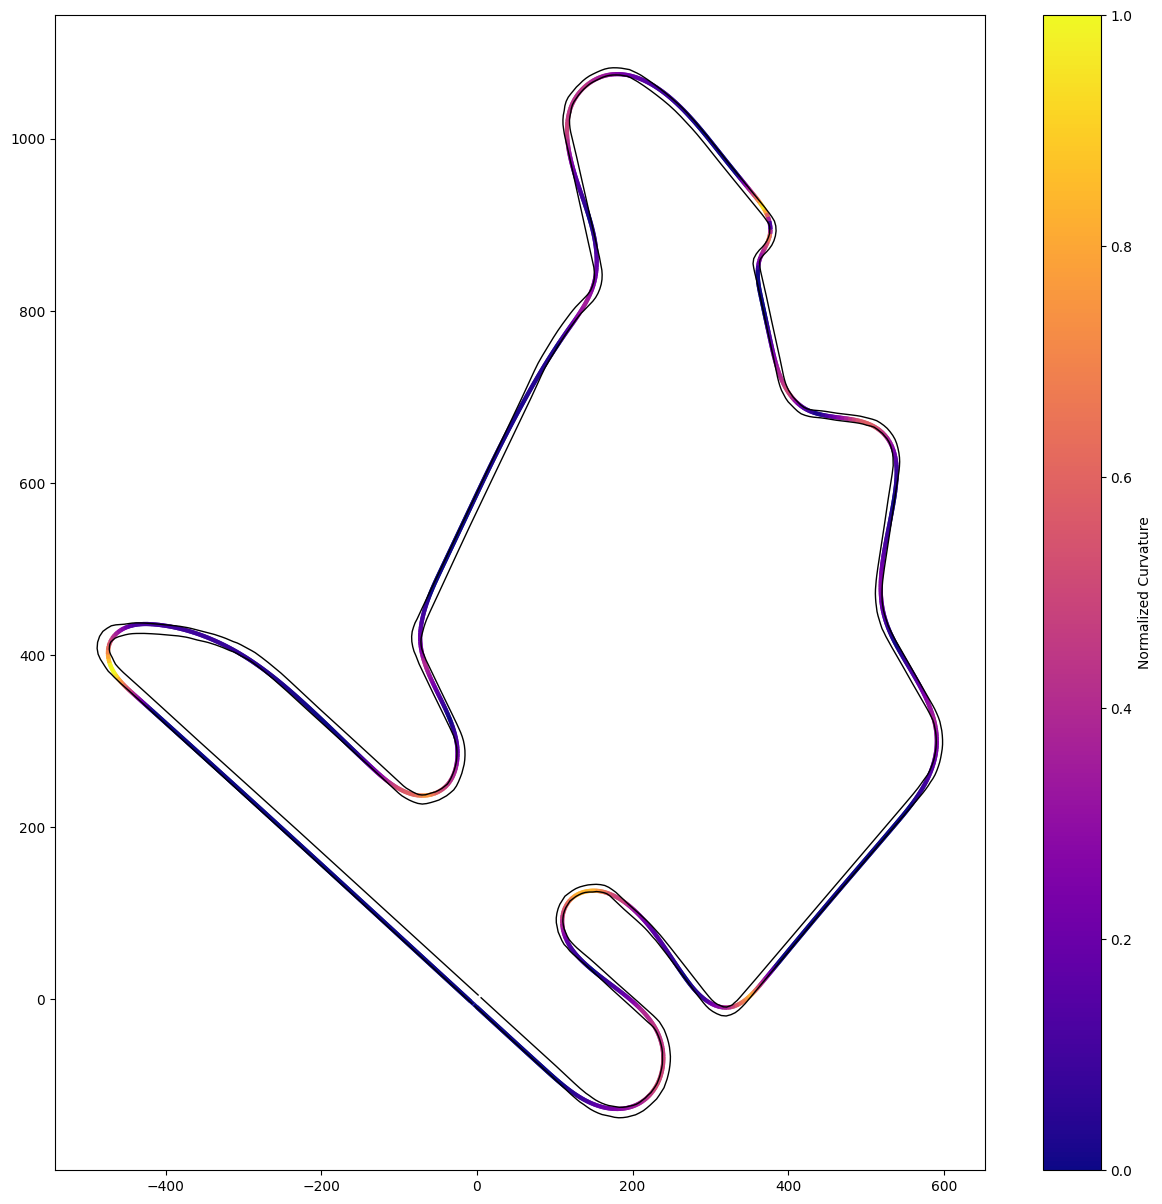

In [44]:
import matplotlib.cm as cm

def draw_track(center_x=None, center_y=None, width=None, height=None, racing_line_data=None, track_data=None):
    # Get colormap
    cmap = cm.plasma
    
    # Plot data points
    fig, ax = plt.subplots(figsize=(15, 15))
    if center_x is not None and center_y is not None and width is not None and height is not None:
        ax.set_xlim(center_x - width / 2, center_x + width / 2)
        ax.set_ylim(center_y - height / 2, center_y + height / 2)
    
    # Plot the racing line
    for i in range(1, len(racing_line_data['x_m'])):
        x = [racing_line_data['x_m'][i-1], racing_line_data['x_m'][i]]
        y = [racing_line_data['y_m'][i-1], racing_line_data['y_m'][i]]
        color = cmap(racing_line_data['curvature'][i])
        ax.plot(x, y, color=color, linewidth=3)
    
    ax.plot(track_data['left_edge_x_m'], track_data['left_edge_y_m'], 'k', linewidth=1) # Left edge
    ax.plot(track_data['right_edge_x_m'], track_data['right_edge_y_m'], 'k', linewidth=1) # Right edge
    
    # Add a colorbar to the plot to indicate curvature values
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='vertical', label='Normalized Curvature')
    
    return fig, ax

# Drawing the track with curvature
draw_track(racing_line_data=racing_line_data, track_data=track_data)
plt.savefig('fig/budapest_curvature.svg', format='svg')
